In [1]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm
from pathlib import Path

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [2]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [21]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [32]:
rf_model = RandomForestClassifier(
    n_estimators=5,
    max_depth=50,
    random_state=1105
)

rf_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = rf_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

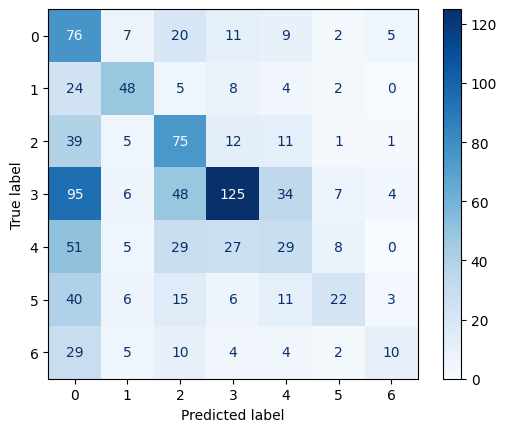

Accuracy: 0.3850
Precision: 0.4340
Recall: 0.3699
f1 score: 0.3644


In [43]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [44]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = lr_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

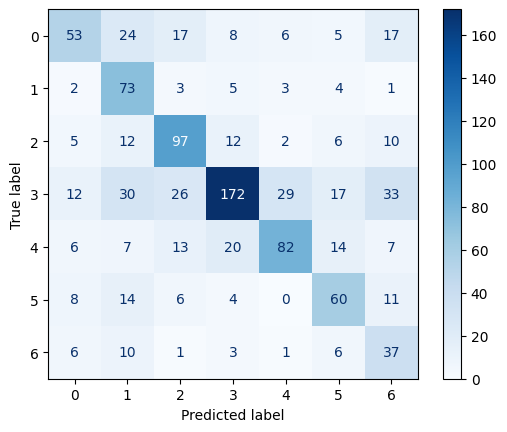

Accuracy: 0.5740
Precision: 0.5557
Recall: 0.5905
f1 score: 0.5535


In [45]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [46]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 4.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(data.x[data.train_mask], data.y[data.train_mask])
y_pred = svc_model.predict(data.x[data.test_mask])
y_true = data.y[data.test_mask].numpy()

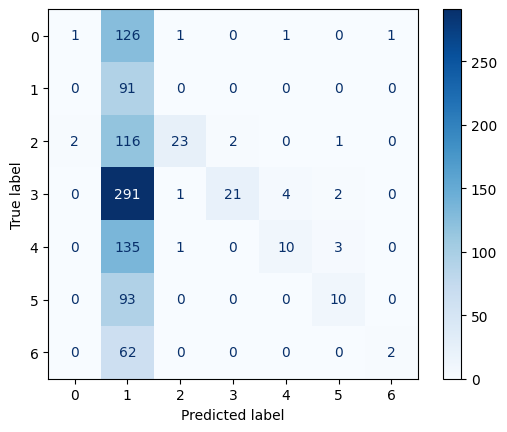

Accuracy: 0.1580
Precision: 0.5984
Recall: 0.2041
f1 score: 0.1342


In [47]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [99]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [104]:
data.train_mask.sum()

tensor(140)

In [101]:
data.val_mask.sum()

tensor(500)

In [102]:
data.test_mask.sum()

tensor(1000)

In [49]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [55]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, dataset.num_classes)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

432,519
MLP model number of params: 432,519


In [56]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 100
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp)  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp)
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 2.0739 / Val_loss: 2.0017
Epoch: 002, Train_loss: 2.1012 / Val_loss: 2.0304
Epoch: 003, Train_loss: 2.0370 / Val_loss: 2.0697
Epoch: 004, Train_loss: 2.0247 / Val_loss: 2.0985
Epoch: 005, Train_loss: 2.0932 / Val_loss: 2.1136
Epoch: 006, Train_loss: 2.0557 / Val_loss: 2.1268
Epoch: 007, Train_loss: 2.0503 / Val_loss: 2.1345
Epoch: 008, Train_loss: 2.0512 / Val_loss: 2.1349
Epoch: 009, Train_loss: 2.0961 / Val_loss: 2.1338
Epoch: 010, Train_loss: 2.0629 / Val_loss: 2.1314
Epoch: 011, Train_loss: 1.9979 / Val_loss: 2.1318
Epoch: 012, Train_loss: 2.0702 / Val_loss: 2.1346
Epoch: 013, Train_loss: 2.1085 / Val_loss: 2.1286
Epoch: 014, Train_loss: 2.0750 / Val_loss: 2.1191
Epoch: 015, Train_loss: 2.0155 / Val_loss: 2.1091
Epoch: 016, Train_loss: 2.0364 / Val_loss: 2.0996
Epoch: 017, Train_loss: 2.0228 / Val_loss: 2.0886
Epoch: 018, Train_loss: 2.0666 / Val_loss: 2.0787
Epoch: 019, Train_loss: 2.0433 / Val_loss: 2.0687
Epoch: 020, Train_loss: 1.9516 / Val_loss: 2.0598


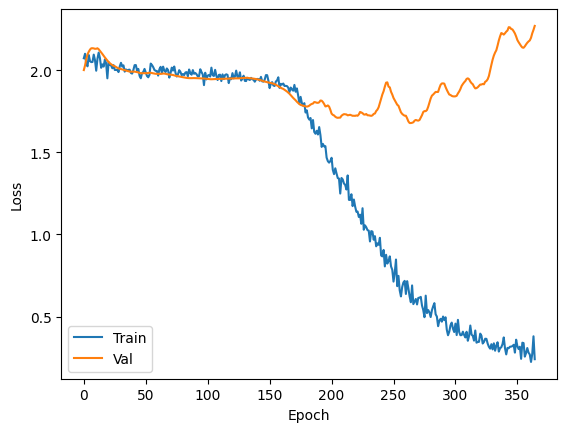

In [57]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

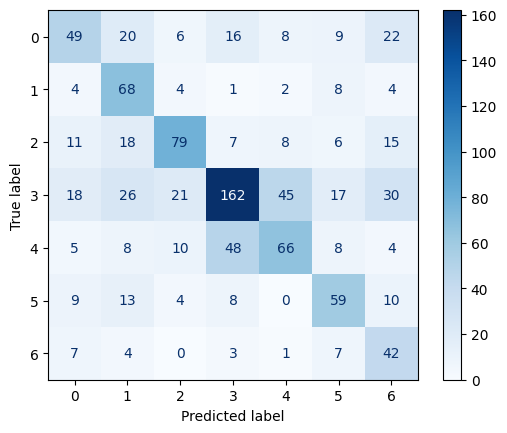

Accuracy: 0.1580
Precision: 0.5984
Recall: 0.2041
f1 score: 0.1342


In [59]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
pred = out.argmax(dim=1)  # Use the class with highest probability.

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [80]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, dataset.num_classes)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

432,519
GCN model number of params: 432,519


In [81]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 100
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 2.1426 / Val_loss: 2.2492
Epoch: 002, Train_loss: 2.2844 / Val_loss: 2.3016
Epoch: 003, Train_loss: 2.2533 / Val_loss: 2.2441
Epoch: 004, Train_loss: 2.1574 / Val_loss: 2.1858
Epoch: 005, Train_loss: 2.1658 / Val_loss: 2.1746
Epoch: 006, Train_loss: 2.0786 / Val_loss: 2.1863
Epoch: 007, Train_loss: 2.0373 / Val_loss: 2.1177
Epoch: 008, Train_loss: 2.0999 / Val_loss: 2.0360
Epoch: 009, Train_loss: 1.9531 / Val_loss: 2.0469
Epoch: 010, Train_loss: 2.0118 / Val_loss: 2.0315
Epoch: 011, Train_loss: 2.1453 / Val_loss: 2.0590
Epoch: 012, Train_loss: 1.9325 / Val_loss: 2.0015
Epoch: 013, Train_loss: 1.9053 / Val_loss: 1.9400
Epoch: 014, Train_loss: 1.8840 / Val_loss: 1.9638
Epoch: 015, Train_loss: 2.0073 / Val_loss: 2.0244
Epoch: 016, Train_loss: 1.9404 / Val_loss: 2.0662
Epoch: 017, Train_loss: 1.8689 / Val_loss: 1.9701
Epoch: 018, Train_loss: 1.9624 / Val_loss: 1.9566
Epoch: 019, Train_loss: 1.9579 / Val_loss: 1.9508
Epoch: 020, Train_loss: 2.0019 / Val_loss: 2.0095


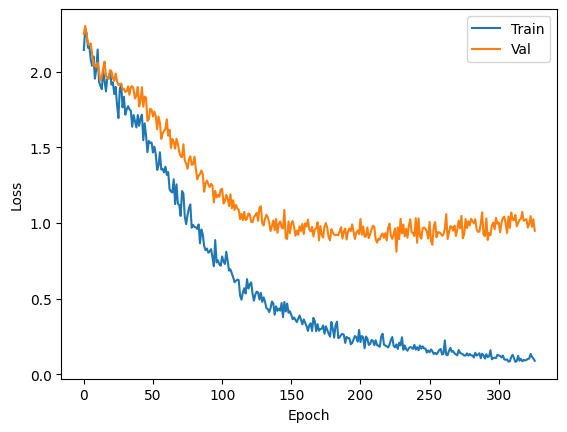

In [82]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [85]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

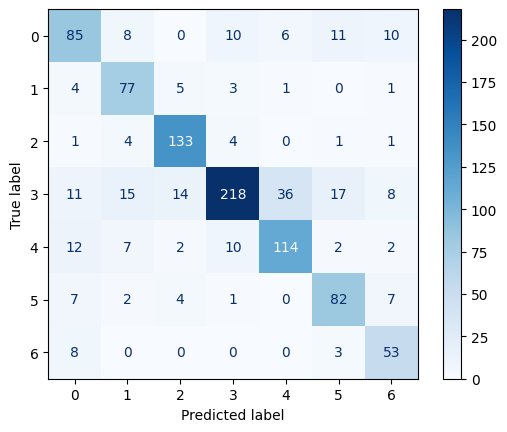

Accuracy: 0.7620
Precision: 0.7361
Recall: 0.7852
f1 score: 0.7552


In [86]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")

In [94]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, dataset.num_classes)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

435,221
GAT model number of params: 435,221


In [95]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 50
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 2.6404 / Val_loss: 2.1823
Epoch: 002, Train_loss: 2.2354 / Val_loss: 2.3591
Epoch: 003, Train_loss: 2.2074 / Val_loss: 2.0924
Epoch: 004, Train_loss: 2.2613 / Val_loss: 2.2845
Epoch: 005, Train_loss: 2.2620 / Val_loss: 2.3240
Epoch: 006, Train_loss: 2.1478 / Val_loss: 2.2707
Epoch: 007, Train_loss: 2.2204 / Val_loss: 2.3061
Epoch: 008, Train_loss: 2.2953 / Val_loss: 2.1798
Epoch: 009, Train_loss: 2.0806 / Val_loss: 2.1396
Epoch: 010, Train_loss: 2.3505 / Val_loss: 2.2690
Epoch: 011, Train_loss: 2.1533 / Val_loss: 2.1901
Epoch: 012, Train_loss: 2.5068 / Val_loss: 2.3265
Epoch: 013, Train_loss: 2.1459 / Val_loss: 2.1548
Epoch: 014, Train_loss: 2.1611 / Val_loss: 2.0522
Epoch: 015, Train_loss: 2.3392 / Val_loss: 2.2374
Epoch: 016, Train_loss: 2.2371 / Val_loss: 2.2337
Epoch: 017, Train_loss: 2.0604 / Val_loss: 2.1787
Epoch: 018, Train_loss: 2.0691 / Val_loss: 2.2194
Epoch: 019, Train_loss: 2.2440 / Val_loss: 2.1892
Epoch: 020, Train_loss: 2.1422 / Val_loss: 2.1534


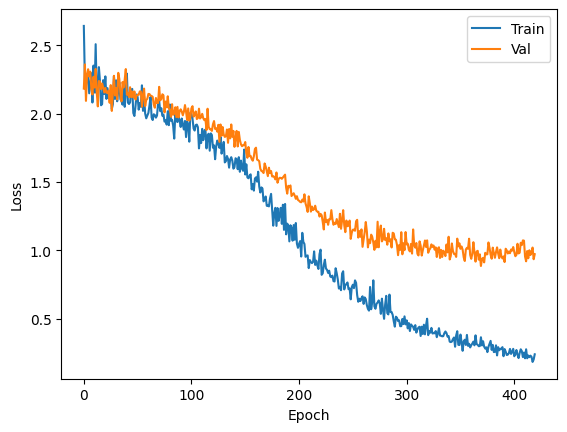

In [96]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [97]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
# pred = F.sigmoid(out).round()
pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

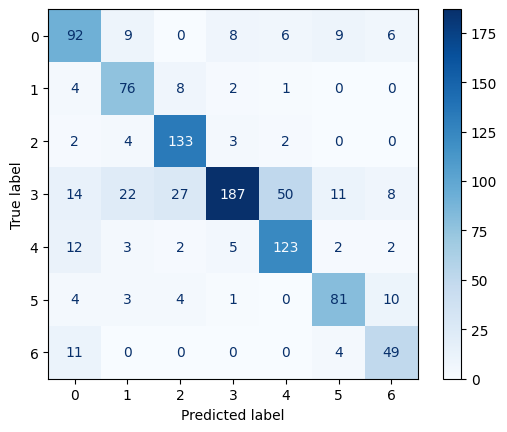

Accuracy: 0.7410
Precision: 0.7242
Recall: 0.7757
f1 score: 0.7405


In [98]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred, average='macro'):.4f}")